In [1]:
import pandas as pd
from datetime import datetime as dt
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/marco/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Studying Bitcoin's Historical Volatility

Bitcoin's volatility is a source of continues debates because a high volatility impairs its use as medium of exchange and unit of account in economic exchanges: it therefore prevents Bitcoin to be adopted as money. 

During Bitcoin's early days, Bitcoin's supporters advanced the hypothesis that its future volatility would be inversely correlated to the size of its market capitalization, i.e the outstanding value of all Bitcoins. 

In early 2021, Bitcoin's market capitalization reached 1 trillion dollars, putting it on pars with major fiat currencies such as the Swiss franc and a considerable fraction of the investable gold market. But is Bitcoin's volatility lower today than when its marketcap was hundreds of time smaller? This is the focus on this investigation.

## Defining Volatility

A tradable asset can be described by a discrete time series of prices $S_{n}$. This time series is a sample, taken with a constant sampling frequency that can be daily, hourly or even at the minute level, of the entire tick-by-tick, trade-by-trade price history of the asset, that for we can consider continous. That price history is the population from with the extract our sample: the aim of our stastitical analysis is inferring properties of the population by analyzing data from the sample, and we will see how. 

Volatility is generally defined as a measure of dispersion of the price returns in the time series. Since we are analyzing data fromn a sample taken from the population, we can only estimate volatility using statistical estimators. Ideally, we want a statistical estimator that it is unbiased and efficient. 
In statistics, bias is defined as the difference between an estimator expected value and the true value of the parameter being estimated. 
We also want an estimator that is stable from sample to sample: the less prone to sampling error an estimator is, the more efficient it is.

**Volatility as Stastistical Estimator** The most common statistical estimator used for volatility is the square rooot of the variance of the price returns in the sample, which also it is the definition for the standard deviation of a normal distribution. Volatility is usually reported as an annualized metric, so that the resulting variance has to be multiplied by the number of trading periods in one year.  

Let's assume that we sample a time series of N consecutive prices $S_{n}$ of our security. Then the sample variance is defined as

\begin{align*}
s^2 = \frac{1}{N} \sum_{i=1}^N \left(x_i - \bar x \right)^2
\end{align*}

where $ x_i = \ln\left(\frac{S_i}{S_{i-1}}\right) $  and $\bar x = \frac{1}{N} \sum_{i=1}^N x_i $ is the mean log returns in the sample, also called drift. As the drift, which is a log return, may greatly depend on the sample considered and it is should be small in the period considered, by setting $\bar x = 0$ we reduce a source of potential noise in our volatility estimate. 

**From Sample to Population Estimate** Since we are actually interested in the population variance, we must know how to infer it from the sample variance. The sample variance defined above is a well known *biased estimator* of the population variance $\sigma^2$, so that it needs to be multiplied by a factor $n/(n-1)$ to remove the bias {doc}`statistics.ipynb` (this is called Bernoulli's correction):

\begin{align*}
\sigma^2 = \frac{N}{N - 1} s^2
\end{align*}


We can already see that the sample size N is quite important, but it becomes even more important if we consider the variance of the sample variance itself:

\begin{align*}
var(s) \approx \frac{\sigma^2}{2N} 
\end{align*}

In fact, for small $N$ such as the commonly used $N=20$ or $N=30$, the uncertainity on the sample variance can be quite high. Much better to use N of 60 and above.

So why shouldn't we use always a high N in our volatility estimate? Firstly, a high N could make jumps or trading discountinity persist in our estimate, leading to an overestimate. Secondly, since often we use daily closes as pricing data, looking up to 60 days in the past may provide us with information on volatility which are not anymore current. 



In [2]:
from pathlib import Path
csv_path = Path.cwd() / 'data' / 'bitstamp_hourly.csv'
df = pd.read_csv(csv_path)
df['timestamp'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

In [3]:

def estimate_realized_volatility(closes):
    sample_variance = 0

    for i in range(0, len(closes) - 1):
        daily_log_return = np.log((float(closes[i + 1])/ float(closes[i])))
        sample_variance += np.power(daily_log_return, 2)

    pop_variance = (sample_variance) / (60 - 1)
    return np.sqrt(365*24) * np.sqrt(pop_variance)


In [4]:
volatilities = df['close'].rolling(window=60).apply(estimate_realized_volatility, raw=True, engine='numba')
df = df.assign(volatilities=volatilities.values)


**Bitcoin Data** Although Bitcoin is traded 24/7 globally, it does often presents pricing discountinity due to jumps of its price. Moreover, volatility regimes shift in Bitcoin happens very quickly: 60 daily closes would be a far too long time period to have an up-to-date volatility estimate. 
If we want to be accurate in our estimate of volatility and at the same time avoid the impact of the jumps on the data, we can use a high N but use more granular data, such as hourly data, instead of daily closes. 
We must take that in consideration when we annualize the volatility by multiplying with the correct factor. 


## Analysis
In the first chart, I plotted Bitcoin's close on close annualized hourly volatility with a period of 60 hours. 


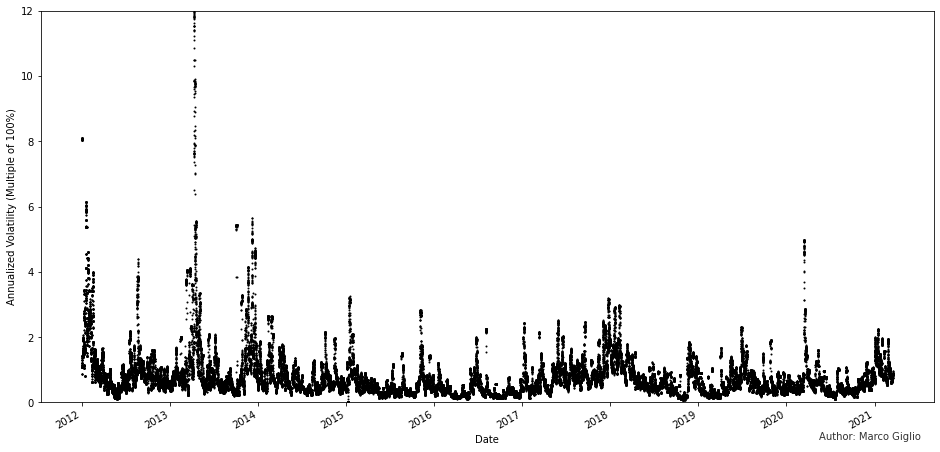

In [5]:
plt.rcParams['figure.figsize'] = [16, 8]
ax = df.plot(x='timestamp', y='volatilities', style='ko', markersize=1)
ax.get_legend().remove()
fig = ax.get_figure()
fig.text(0.8, 0.15, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)
plt.xlabel('Date')
plt.ylim(0,12)
plt.ylabel('Annualized Volatility (Multiple of 100%)')
plt.savefig('volatility.png', dpi=300)


Already from this very high view graph, we can see a few things:
* Bitcoin's volatility presents many extreme spikes, which have become considerably more rare in recents years
* Bitcoin's tipical volatility remains substantial and it shows an upward trending pattern during bull markets and downward during bear markets. From this high view, it doesn't not appear to have diminished significantly, if not at all. 
* The March 2020 crash was an outlier comparable to 2014's events

### Comparing the Histograms of Volatilities at Different Times
How can we extract more information from the data? Since we have pricing data with a decent resolution, we can build histograms of the volatilites, by taking slices of our sample, and see how they have changed: i.e we want to compare volatility regimes at different periods in the history of Bitcoin. 


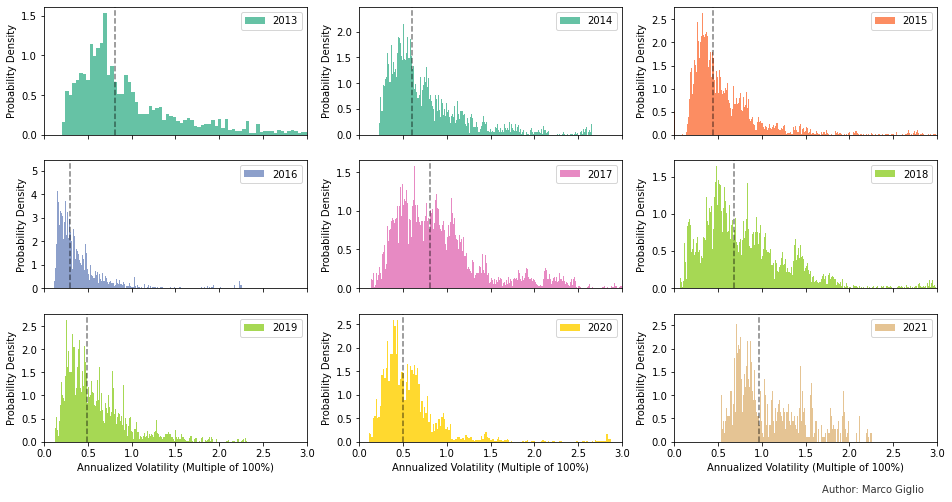

In [37]:
from matplotlib import cm

cmap = cm.get_cmap('Set2')

fig, axes = plt.subplots(nrows=3, ncols=3)

for i in range(0,9):
    j,k = np.unravel_index(i, shape=(3,3), order='C')
    start = df['timestamp'] > dt.strptime(str(2013 + i) + '-01-01','%Y-%m-%d')
    end = df['timestamp'] < dt.strptime(str(2014 + i) + '-01-01','%Y-%m-%d')
    
    ax = df[start & end]['volatilities'].plot.hist(ax=axes[j,k], bins=300, color=cmap(float(i)/10), label=str(2013 + i), density=True, sharex=True)
    median = df[start & end]['volatilities'].median()
    ax.axline((median, 0), (median, 1), linestyle='--', color='black', alpha=0.5)
    axes[j, k].legend()


for i,ax in enumerate(axes.flat):
    ax.set(xlabel='Annualized Volatility (Multiple of 100%)', ylabel='Probability Density')
    ax.set(xlim=(0,3))
   
    
fig.text(0.8, 0.05, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)

plt.savefig('distribution_subplots.png', dpi=300)


The histograms show the distribution of volatilities within the years of 2012, 2016, 2017 and 2020. The dashed line is the median volatility for that year. We can notice a few things:
* The distribution of volatilities is highly skewed and it has also high kurtosis (fat tails)
* The median volatility in 2012 and 2017 is elevated and very similar. 
* 2016 was a very atypical year: the volatility distribution is very skewed and the median volatility is much lower than in later years.
* 2020 volatility is higher than 2016

Could it be that our conclusions are due to the way we sliced the data? 

### Mean and Median Over Time using Rolling Windows 
Another way to analize the data, it is to plot the median and mean over time of a rolling window of our sample. We can also compare different window sizes to see how the median and mean value change. 


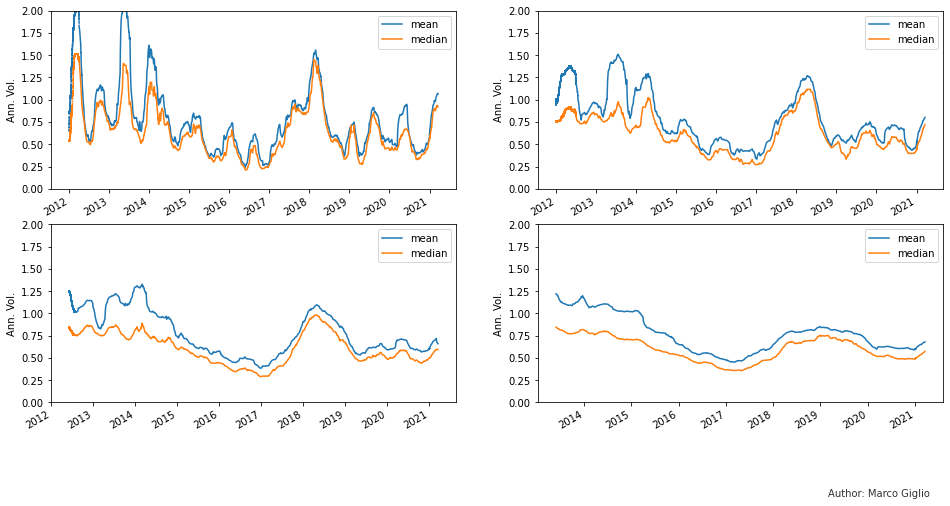

In [7]:
# Compute the mean and the std of the data over a rolling 3, 6, 12, 24-months windows 
cmap = cm.get_cmap('Set2')
fig, axes = plt.subplots(nrows=2, ncols=2)
window_sizes = [3*30*24, 6*30*24, 12*30*24, 24*30*24]
for i, window_size in enumerate(window_sizes):
    mean = df['volatilities'].rolling(window=window_size).mean()
    median = df['volatilities'].rolling(window=window_size).median()
    std = df['volatilities'].rolling(window=window_size).std()
    df = df.assign(mean=mean.values)
    df = df.assign(median=median.values)
    df = df.assign(std=std.values)
    j = 1 if i > 1 else 0
    df.plot(ax=axes[j, i%2], x='timestamp', y=['mean','median'],ylabel='Ann. Vol.')
                
for i, ax in enumerate(axes.flat):
    ax.set(ylim=(0,2))
    ax.set(xlabel=None)
    
    
fig.text(0.8, 0.05, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)


plt.savefig('rolling_subplot.png', dpi=300)


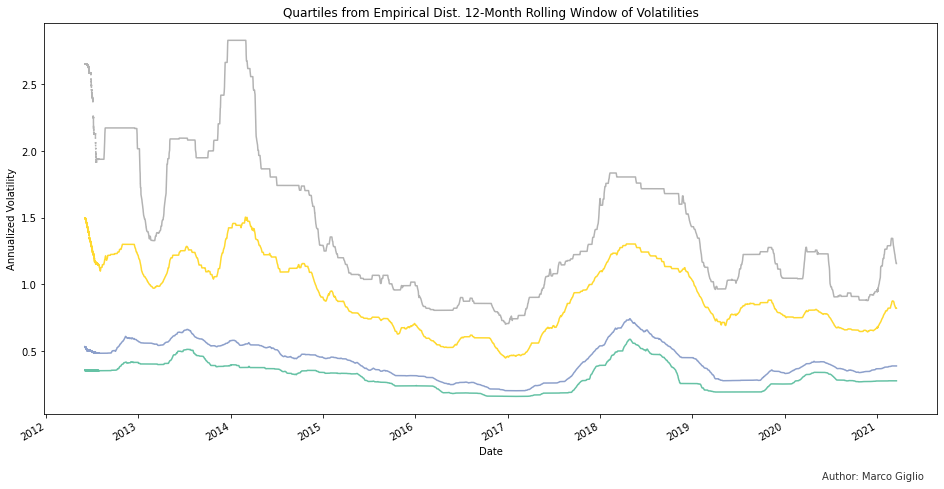

In [28]:
window_size = 12*30*24
quantiles = [.1, .25, .75, .90]

for quantile in quantiles: 
    data = df['volatilities'].rolling(window=window_size).quantile(quantile)
    serie = pd.Series(data, name=str(quantile))
    df[serie.name] = serie
    
ax = df.plot(x='timestamp', y=['0.1', '0.25', '0.75', '0.9'], cmap=cmap, legend=False, ylabel='Annualized Volatility', xlabel='Date', title='Quartiles from Empirical Dist. 12-Month Rolling Window of Volatilities')

fig = ax.get_figure()
fig.text(0.8, 0.1, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)

plt.savefig('quartiles.png', dpi=300)



# Future Research Direction
* **Alternative estimators**: the close-on-close volatility estimator cannot handle jumps in returns well, as they increase volatility for the entire window/period before dropping out. Alternatives model exists, such as the Exponentially Weighted Moving Average (EWMA) and the family of GARCH models. 
* **High Frequency Data**: the easiness in which today we can collect and process high-frequency pricing data has clearly have an impact on volatility measures: today, it is possible to collect tick-by-tick/sub-second pricing data. But on timescales so short, market microstructure, such as the bid-ask spread and exchange liquidity will have a large effect on the volatility estimate. It is also possible that high frequency data would show that difference currency pairs presents different volatilities. 
* **Volatility of Volatility**: How does volatility itself change over time and how it has been changing in the last decade?